这段代码中与汽轮机（Turbine）操作相关的关键部分：

1. **汽轮机负荷跟随（Turbine Load Following）**:
   ```vb
   ' TURBINE LOAD FOLLOWING
   If (MFACT(9) = False) Then
       If ((TIME >= TRKT Or Abs(PWSP * 100 - PWR) > 1) And IRKT = 0) Then
           ' ... 
           ElseIf (TIME > TRKT And TIME < TRKF) Then
               POWR = PWSP
               TBLD = PWR0 + (PWSP - PWR0) / Abs(PWSP - PWR0 + 0.0001) _
                   * RAMP / 60 / 100 * (TIME - TRKT)
           Else
               TBLD = PWSP
               PWR0 = TBLD
               IRKT = 0
               ' ...
           End If
       End If
   End If
   ```

2. **汽轮机紧急停车（Turbine Trip）**:
   ```vb
   ' TURBINE TRIP & STOP VALVE CLOSURE ' 2013
   If (fMainForm.ValveTCV(0).Position = 0 And Not MFACT(9) Or MFACT(9) And fMainForm.ValveTCV(0).Position = 100) Then
       TBTP = TIME
       If TSCRAM > TBTP Then TSCRAM = TBTP + TRXT
       fMainForm.TurbineControl1.State = False
       TBLD = 0
       fMainForm.ValveTCV(0).Position = 0
       fReportsForm.AddToList (Format(TIME, "000000.0") & " sec, Turbine trip  ")
       TBSP = 3                  ' turbine trip RPM reset to 3 RPM 2010
       fMainForm.ctlGenBkr.State = 0
   End If
   ```

3. **与反应堆停机后的汽轮机操作相关**:
   ```vb
   '  TURBINE TRIP FOLLOWING RX TRIP
   TBLD = 0                       ' 2011

   '        TBV PRESSURE CONTROL
   ITBV = 1
   fMainForm.TripTurbine.State = True                 ' lcp11 ITBV
   fMainForm.TurbineControl1.State = False            ' lcp11
   ' lcp19         If (MFACT(9) = False) Then MFTIME(9) = TIME
   If (MFACT(9) = False) Then MFACT(9) = True        ' LCP19
   PWSP = 0#
   POWR = 0
   ICORE = 1
   ```

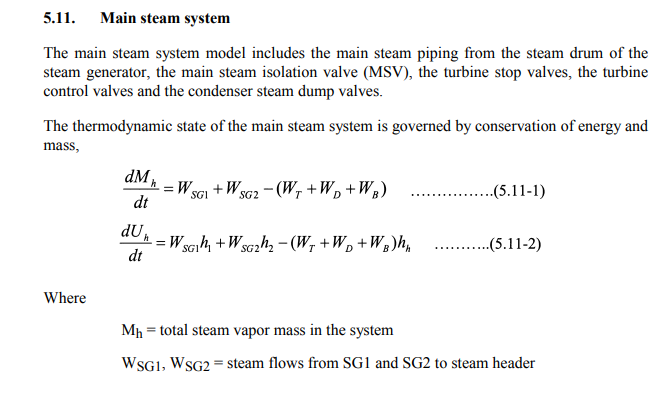
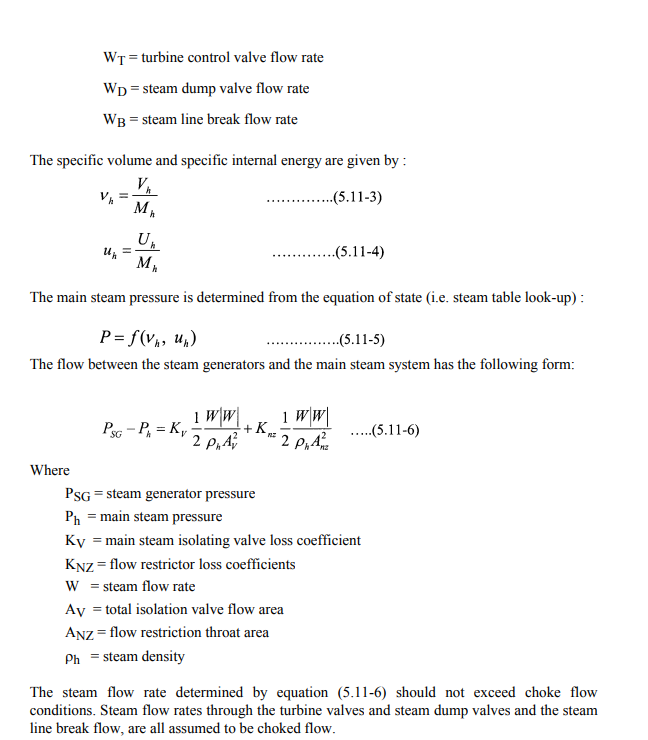

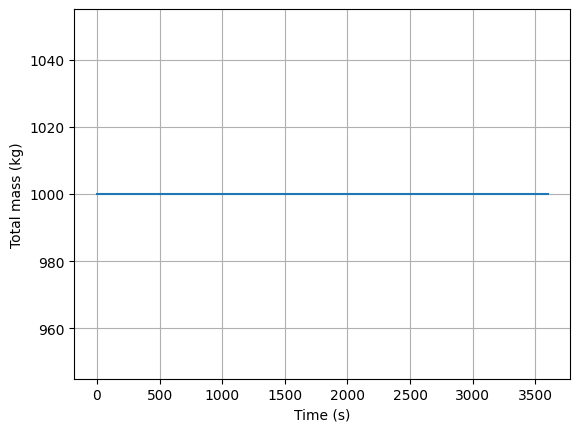

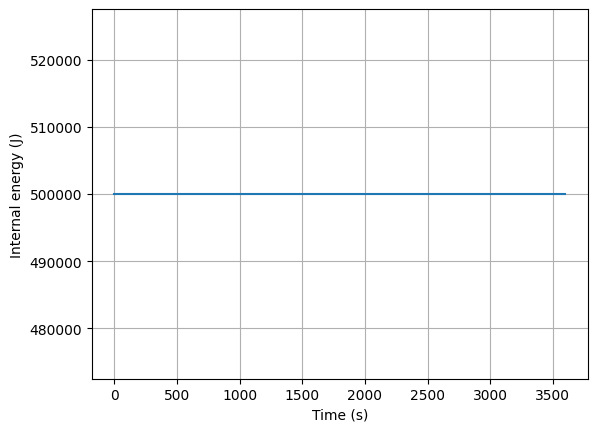

In [27]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

# Define the system of differential equations
def steam_system(y, t, W_SG1, W_SG2, W_T, W_D, W_B, K_V, K_NZ, A_V, A_NZ, rho_h):
    # Unpack the current values of y
    M_h, U_h = y

    # Ensure W_T is not negative
    W_T = max(W_T, 0)
    # Equations given in the problem (converted from the provided images)
    dMh_dt = W_SG1 + W_SG2 - (W_T + W_D + W_B)
    dUh_dt = W_SG1 * h_1 + W_SG2 * h_2 - ((W_T + W_D + W_B) * h_h)

    # The system of differential equations
    dydt = [dMh_dt, dUh_dt]
    return dydt

# System parameters and initial conditions (hypothetical values)
W_SG1 = 90 # steam flow from SG1
W_SG2 = 60  # steam flow from SG2
W_T = 135     # turbine control valve flow rate
W_D = 10     # steam dump valve flow rate
W_B = 5     # steam line break flow rate
K_V = 0.01  # main steam isolating valve loss coefficient
K_NZ = 0.01 # flow restrictor loss coefficients
A_V = 1     # total isolation valve flow area
A_NZ = 1    # flow restriction throat area
rho_h = 1   # steam density (assumed to be constant for simplicity)

# Control parameters
M_h_target = 1000  # target total steam vapor mass
U_h_target = 500000  # target internal energy
K_p = 0.001  # proportional gain
K_i = 0.001  # integral gain

# Hypothetical enthalpies (these would need to be calculated based on steam tables)
h_1 = 2800  # specific enthalpy for steam flow from SG1
h_2 = 2750  # specific enthalpy for steam flow from SG2
h_h = 2780  # specific enthalpy for total steam vapor

# Initial conditions: M_h0 = initial total steam vapor mass, U_h0 = initial internal energy
M_h0 = 1000  # initial total steam vapor mass in the system
U_h0 = 500000  # initial internal energy

# Time vector (in seconds)
t = np.linspace(0, 3600, 100)  # Simulate for 1 hour

# Solve the system of differential equations
solution = odeint(steam_system, [M_h0, U_h0], t, args=(W_SG1, W_SG2, W_T, W_D, W_B, K_V, K_NZ, A_V, A_NZ, rho_h))

# Extract the results
M_h = solution[:, 0]
U_h = solution[:, 1]

plt.figure(1)
plt.plot(t, M_h)
plt.xlabel('Time (s)')
plt.ylabel('Total mass (kg)')
plt.grid()

plt.figure(2)
plt.plot(t, U_h)
plt.xlabel('Time (s)')
plt.ylabel('Internal energy (J)')
plt.grid()

